In [21]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
tf.config.list_physical_devices('GPU')
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D, MaxPooling1D
from tensorflow.keras.layers import LSTM, Embedding, Conv1D
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import Precision, Recall

In [5]:
df = pd.read_parquet('clean_data.pqt')

In [7]:
X= df['comment_text']
y= df.drop(['id','comment_text'], axis=1)
print(y)

X_train, X_valid, ytrain, yvalid = train_test_split(X,y,test_size=.3, random_state=77)
print(X_train.shape[0])
print(X_valid.shape[0]) 

        toxic  severe_toxic  obscene  threat  insult  identity_hate
0           0             0        0       0       0              0
1           0             0        0       0       0              0
2           0             0        0       0       0              0
3           0             0        0       0       0              0
4           0             0        0       0       0              0
...       ...           ...      ...     ...     ...            ...
159566      0             0        0       0       0              0
159567      0             0        0       0       0              0
159568      0             0        0       0       0              0
159569      0             0        0       0       0              0
159570      0             0        0       0       0              0

[159571 rows x 6 columns]
111699
47872


In [13]:
MAX_VOCAB_SIZE = 200000
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(X_train)
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_valid = tokenizer.texts_to_sequences(X_valid)

In [14]:
word2idx = tokenizer.word_index
V = len(word2idx)
print(V)

150507


In [15]:
data_train = pad_sequences(sequences_train)
print(data_train.shape)
T= data_train.shape[1]
data_valid = pad_sequences(sequences_valid, maxlen=T)
print(data_valid.shape)

(111699, 1250)
(47872, 1250)


In [47]:
X_train.to_pickle('data_train.pkl')
X_valid.to_pickle('data_valid.pkl')
ytrain.to_pickle('ytrain.pkl')
yvalid.to_pickle('yvalid.pkl')

In [23]:
D=60
m=32
i= Input(shape=(T,))
x= Embedding(V+1, D)(i)
x= Conv1D(m, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x= Conv1D(m*2, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x= Conv1D(m*4, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x= Conv1D(m*8, 3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(6, activation='softmax')(x)

model= Model(i,x)

In [18]:
def history_plots(redux, metric):
    valid = "val_"+metric
    plt.plot(redux.history[metric], label=metric)
    plt.plot(redux.history[valid], label=valid)
    plt.legend()
    plt.show()

In [24]:
model.compile(loss='binary_crossentropy', optimizer= 'adam', metrics=['accuracy', Precision(), Recall()])

r = model.fit(data_train, ytrain, epochs= 25, batch_size=100, validation_data=(data_valid, yvalid))

Epoch 1/25
1117/1117 [==============================] - 72s 60ms/step - loss: 0.1189 - accuracy: 0.9797 - precision_1: 0.0766 - recall_1: 0.1767 - val_loss: 0.1008 - val_accuracy: 0.8323 - val_precision_1: 0.7806 - val_recall_1: 0.1162
Epoch 2/25
1117/1117 [==============================] - 67s 60ms/step - loss: 0.0903 - accuracy: 0.9894 - precision_1: 0.0825 - recall_1: 0.2575 - val_loss: 0.1049 - val_accuracy: 0.9943 - val_precision_1: 0.0957 - val_recall_1: 0.4350
Epoch 3/25
1117/1117 [==============================] - 67s 60ms/step - loss: 0.0803 - accuracy: 0.9620 - precision_1: 0.0849 - recall_1: 0.2617 - val_loss: 0.1082 - val_accuracy: 0.9943 - val_precision_1: 0.0761 - val_recall_1: 0.2504
Epoch 4/25
1117/1117 [==============================] - 67s 60ms/step - loss: 0.0754 - accuracy: 0.8856 - precision_1: 0.0830 - recall_1: 0.2585 - val_loss: 0.1105 - val_accuracy: 0.9903 - val_precision_1: 0.0767 - val_recall_1: 0.2467
Epoch 5/25
1117/1117 [==============================] - 

In [25]:
def f1_derive(hist=r,prc='precision',rcl='recall'):
    vp= 'val_'+prc
    v_re= 'val_'+rcl
    CH_hist= pd.DataFrame(hist.history)
    CH_hist['f1'] =(2*CH_hist[prc]*CH_hist[rcl])/(CH_hist[prc]+CH_hist[rcl])
    CH_hist['val_f1'] =(2*CH_hist[vp]*CH_hist[vp])/(CH_hist[vp]+CH_hist[vp])
    CH_hist.fillna(0,inplace=True)

    plt.plot(CH_hist['f1'], label='f1')
    plt.plot(CH_hist['val_f1'], label='val_f1')
    plt.legend()
    plt.show()

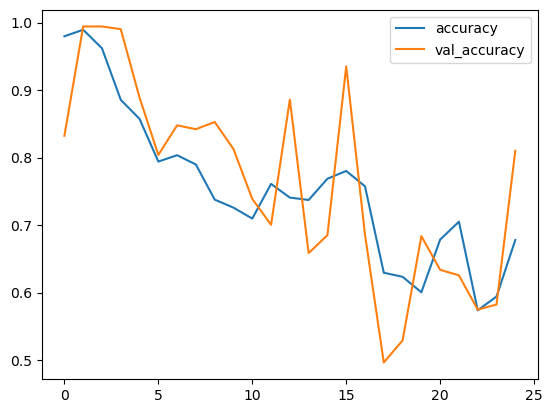

In [26]:
history_plots(r,'accuracy')

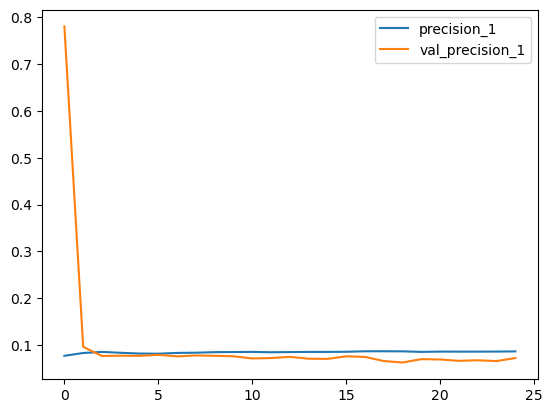

In [27]:
history_plots(r,'precision_1')

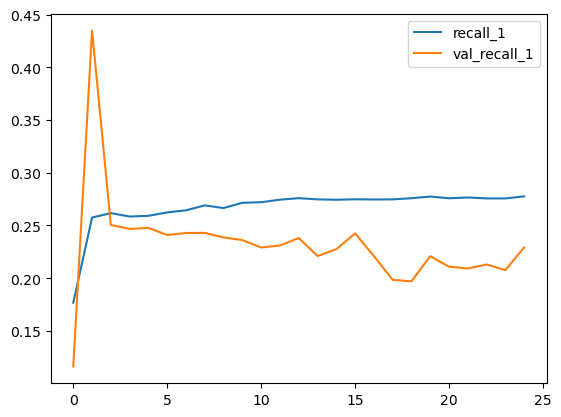

In [28]:
history_plots(r,'recall_1')

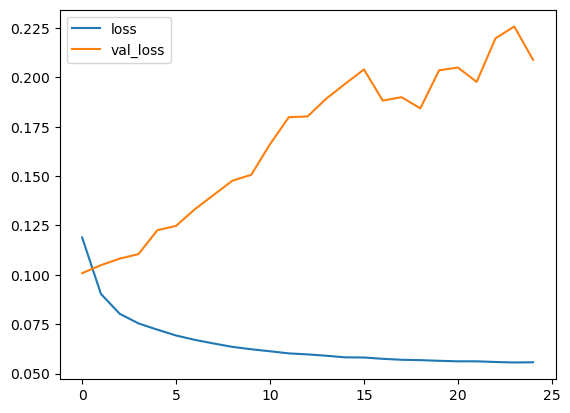

In [38]:
history_plots(r,'loss')

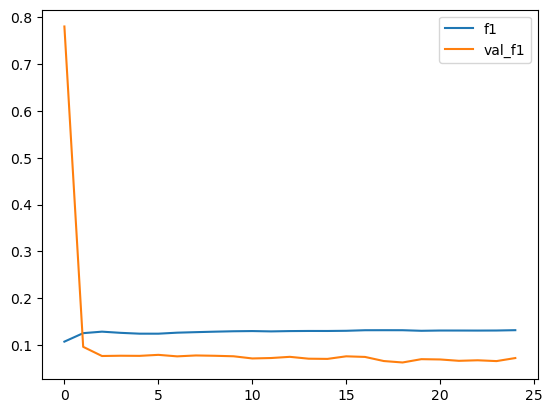

In [29]:
f1_derive(r,'precision_1','recall_1')

In [30]:
D=60
m=32
i= Input(shape=(T,))
x= Embedding(V+1, D)(i)
x= Conv1D(m, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x= Conv1D(m*2, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x= Conv1D(m*4, 3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(6, activation='softmax')(x)

model2= Model(i,x)

In [31]:
model2.compile(loss='binary_crossentropy', optimizer= 'adam', metrics=['accuracy', Precision(), Recall()])

q = model2.fit(data_train, ytrain, epochs= 25, batch_size=100, validation_data=(data_valid, yvalid))

Epoch 1/25
1117/1117 [==============================] - 44s 39ms/step - loss: 0.0908 - accuracy: 0.9474 - precision_2: 0.1029 - recall_2: 0.2872 - val_loss: 0.0527 - val_accuracy: 0.9921 - val_precision_2: 0.1150 - val_recall_2: 0.4334
Epoch 2/25
1117/1117 [==============================] - 44s 39ms/step - loss: 0.0431 - accuracy: 0.9658 - precision_2: 0.1130 - recall_2: 0.4345 - val_loss: 0.0532 - val_accuracy: 0.9558 - val_precision_2: 0.1427 - val_recall_2: 0.4241
Epoch 3/25
1117/1117 [==============================] - 44s 39ms/step - loss: 0.0327 - accuracy: 0.9319 - precision_2: 0.1246 - recall_2: 0.4351 - val_loss: 0.0571 - val_accuracy: 0.9648 - val_precision_2: 0.1369 - val_recall_2: 0.4311
Epoch 4/25
1117/1117 [==============================] - 44s 39ms/step - loss: 0.0267 - accuracy: 0.9071 - precision_2: 0.1256 - recall_2: 0.4367 - val_loss: 0.0585 - val_accuracy: 0.9492 - val_precision_2: 0.1196 - val_recall_2: 0.4322
Epoch 5/25
1117/1117 [==============================] - 

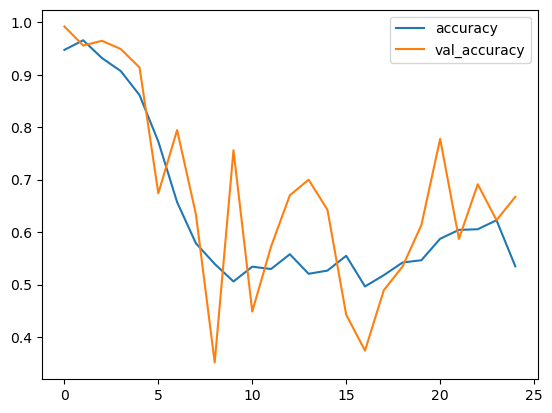

In [32]:
history_plots(q,'accuracy')

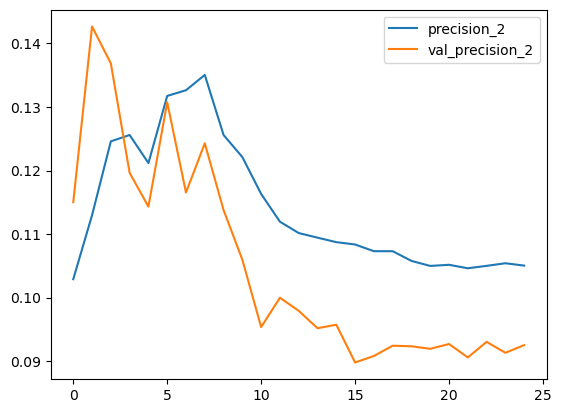

In [34]:
history_plots(q,'precision_2')

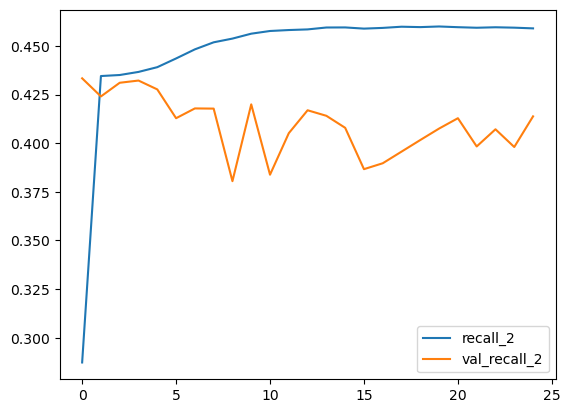

In [35]:
history_plots(q,'recall_2')

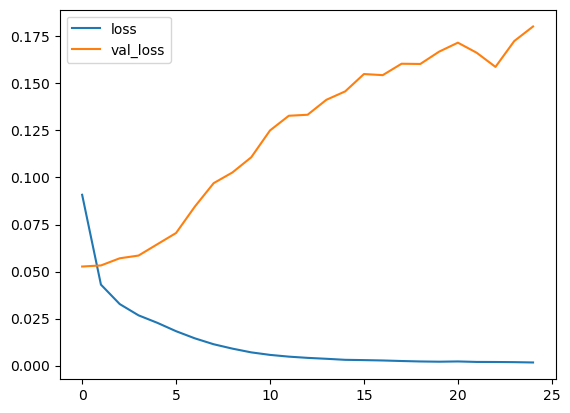

In [36]:
history_plots(q,'loss')

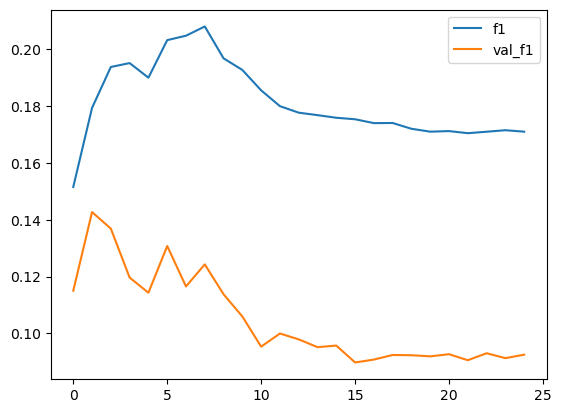

In [37]:
f1_derive(q,'precision_2','recall_2')

In [39]:
D=60
m=64
i= Input(shape=(T,))
x= Embedding(V+1, D)(i)
x= Conv1D(m, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x= Conv1D(m*2, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x= Conv1D(m*4, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x= Conv1D(m*8, 3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(6, activation='softmax')(x)

model3= Model(i,x)

In [40]:
model3.compile(loss='binary_crossentropy', optimizer= 'adam', metrics=['accuracy', Precision(), Recall()])

s = model3.fit(data_train, ytrain, epochs= 25, batch_size=100, validation_data=(data_valid, yvalid))

Epoch 1/25
1117/1117 [==============================] - 135s 120ms/step - loss: 0.1162 - accuracy: 0.9659 - precision_3: 0.0780 - recall_3: 0.1913 - val_loss: 0.1003 - val_accuracy: 0.9943 - val_precision_3: 0.0753 - val_recall_3: 0.2452
Epoch 2/25
1117/1117 [==============================] - 133s 120ms/step - loss: 0.0902 - accuracy: 0.9828 - precision_3: 0.0850 - recall_3: 0.2717 - val_loss: 0.1036 - val_accuracy: 0.7764 - val_precision_3: 0.1644 - val_recall_3: 0.1612
Epoch 3/25
1117/1117 [==============================] - 133s 119ms/step - loss: 0.0807 - accuracy: 0.9458 - precision_3: 0.0833 - recall_3: 0.2623 - val_loss: 0.1092 - val_accuracy: 0.8454 - val_precision_3: 0.0777 - val_recall_3: 0.2421
Epoch 4/25
1117/1117 [==============================] - 133s 120ms/step - loss: 0.0758 - accuracy: 0.8878 - precision_3: 0.0837 - recall_3: 0.2643 - val_loss: 0.1132 - val_accuracy: 0.9934 - val_precision_3: 0.0959 - val_recall_3: 0.4350
Epoch 5/25
1117/1117 [==========================

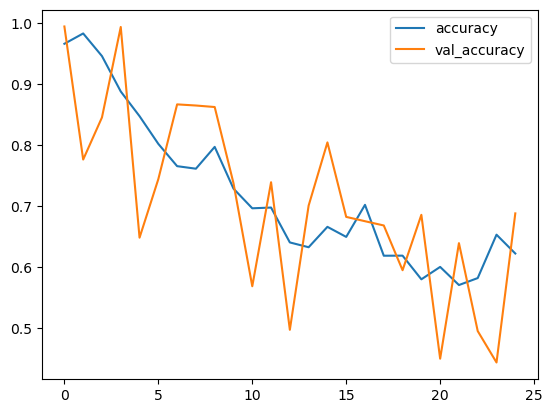

In [41]:
history_plots(s,'accuracy')

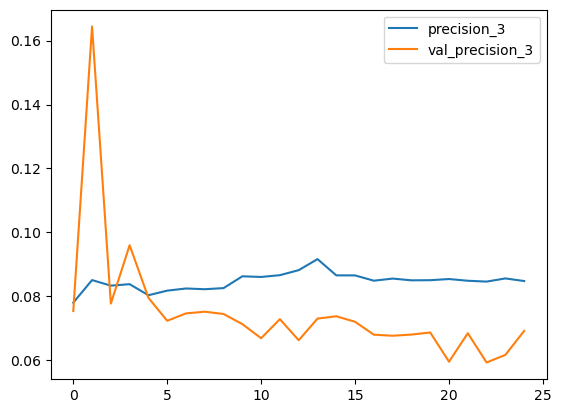

In [42]:
history_plots(s,'precision_3')

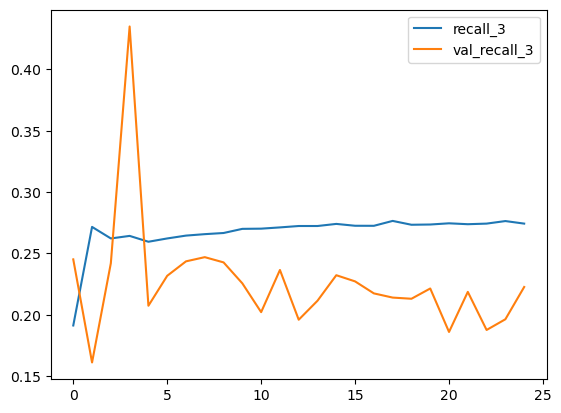

In [43]:
history_plots(s,'recall_3')

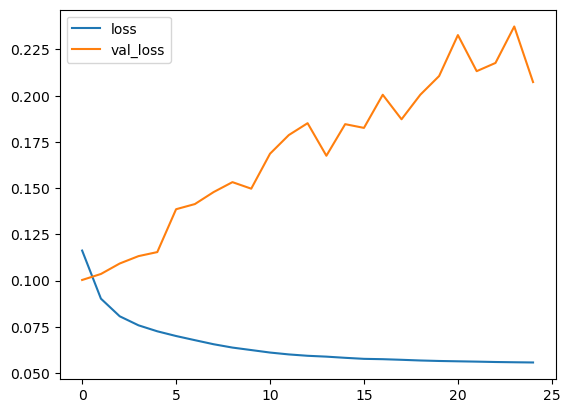

In [45]:
history_plots(s,'loss')

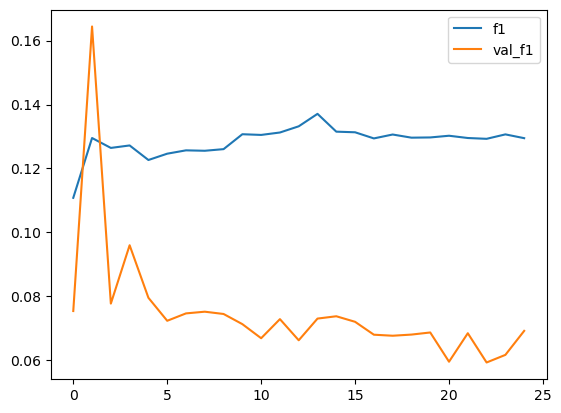

In [46]:
f1_derive(s,'precision_3','recall_3')

In [49]:
D=60
m=32
i= Input(shape=(T,))
x= Embedding(V+1, D)(i)
x= Conv1D(m, 3, activation='sigmoid')(x)
x = MaxPooling1D(3)(x)
x= Conv1D(m*2, 3, activation='sigmoid')(x)
x = MaxPooling1D(3)(x)
x= Conv1D(m*4, 3, activation='sigmoid')(x)
x = MaxPooling1D(3)(x)
x= Conv1D(m*8, 3, activation='sigmoid')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(6, activation='softmax')(x)

model= Model(i,x)

In [50]:
model.compile(loss='binary_crossentropy', optimizer= 'adam', metrics=['accuracy', Precision(), Recall()])

f = model.fit(data_train, ytrain, epochs= 25, batch_size=100, validation_data=(data_valid, yvalid))

Epoch 1/25
1117/1117 [==============================] - 69s 61ms/step - loss: 0.1412 - accuracy: 0.9864 - precision_4: 0.1010 - recall_4: 0.0539 - val_loss: 0.1302 - val_accuracy: 0.9943 - val_precision_4: 0.0941 - val_recall_4: 0.4266
Epoch 2/25
1117/1117 [==============================] - 68s 61ms/step - loss: 0.1202 - accuracy: 0.9939 - precision_4: 0.0585 - recall_4: 0.1114 - val_loss: 0.1168 - val_accuracy: 0.9943 - val_precision_4: 0.0633 - val_recall_4: 0.2013
Epoch 3/25
1117/1117 [==============================] - 69s 61ms/step - loss: 0.1000 - accuracy: 0.9941 - precision_4: 0.0793 - recall_4: 0.2267 - val_loss: 0.1043 - val_accuracy: 0.9943 - val_precision_4: 0.0734 - val_recall_4: 0.2356
Epoch 4/25
1117/1117 [==============================] - 68s 61ms/step - loss: 0.0898 - accuracy: 0.9941 - precision_4: 0.0899 - recall_4: 0.2725 - val_loss: 0.1047 - val_accuracy: 0.9943 - val_precision_4: 0.0762 - val_recall_4: 0.2517
Epoch 5/25
1117/1117 [==============================] - 

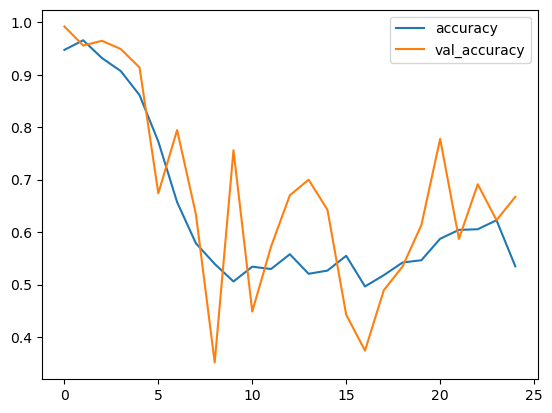

In [ ]:
history_plots(f,'accuracy')

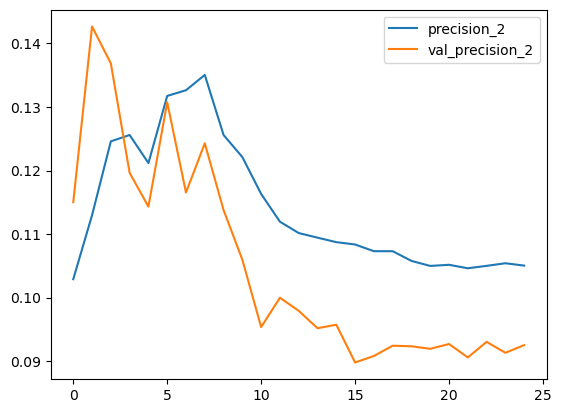

In [ ]:
history_plots(f,'precision_4')

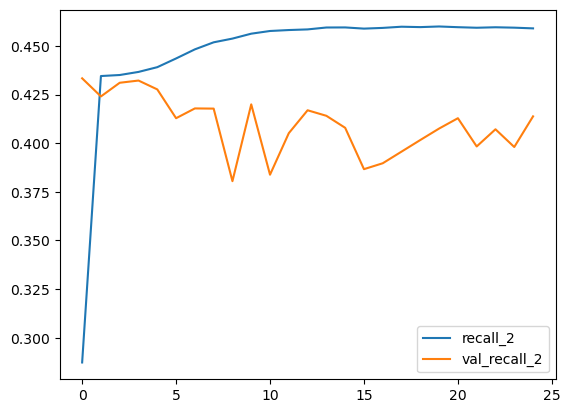

In [ ]:
history_plots(f,'recall_4')

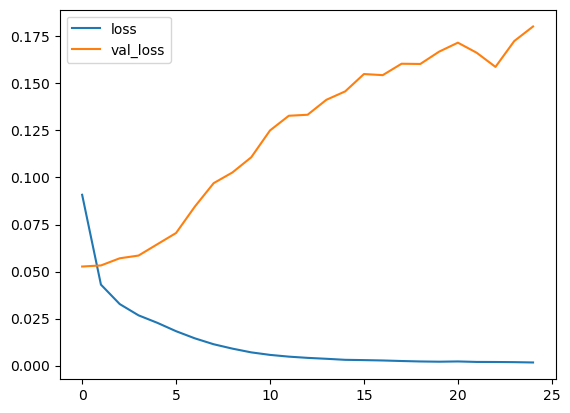

In [ ]:
history_plots(f,'loss')

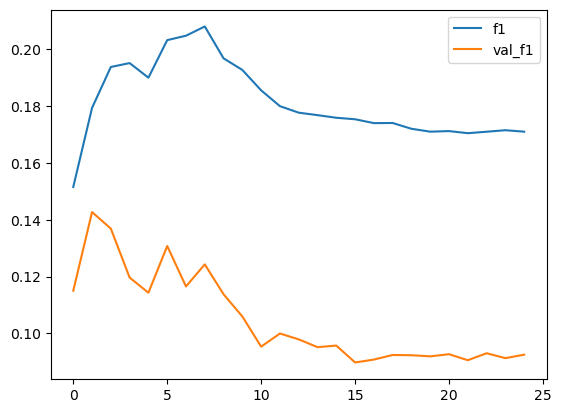

In [ ]:
f1_derive(f,'precision_4','recall_4')